In [1]:
# imports
import numpy as np
import pandas as pd
import os, yaml
osp = os.path
from glob import glob
from importlib import reload
import matplotlib.pyplot as plt
from pathlib import Path
import dill as pickle

import torch
nn = torch.nn
F = nn.functional
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.rcParams['figure.dpi'] = 300

In [ ]:
# amadeus
directories_path="/data/vision/polina/users/clintonw/code/amadeus/config/main_paths.yaml"
import sys
for m in list(sys.modules.keys()):
    if m.startswith("am."):
        del(sys.modules[m])
import am.core.main
A = am.core.main.Nestor(directories_path, module_load="full")

In [2]:
import args as args_module
from data import dataloader, adni, mrigenie, transforms as data_tx
from analysis import analyze, inception, tables, figures
import jobs as job_mgmt
import util
import monai.transforms as mtr
rescale_clip = mtr.ScaleIntensityRangePercentiles(lower=1, upper=99, b_min=0, b_max=255, clip=True, dtype=np.uint8)
rescale_noclip = mtr.ScaleIntensityRangePercentiles(lower=0, upper=100, b_min=0, b_max=255, clip=True, dtype=np.uint8)
pad_adni = mtr.Pad([(0,0),(16,16)])
ANALYSIS_DIR = osp.expanduser("~/code/sitgan/analysis")
%matplotlib inline

# interactive

In [32]:
reload(figures);

In [ ]:
df = tables.get_results_table()
#adni_jobs = df[df["dataset"] == "2D ADNI T1"].index.values
df

In [10]:
job_mgmt.delete_job("a_dit2")
#job_mgmt.rename_job("raw_a_ipg", "fine_raw_a_ipg")

In [8]:
figures.save_sample_outputs_for_job("dit_a_star", slurm=True, overwrite=True)

SLURM accounting storage is disabled
submitit WARNING (2022-03-30 14:19:36,007) - Call #4 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State', '--parsable2', '-j', '89380', '-j', '89385', '-j', '89376', '-j', '89381', '-j', '89379', '-j', '89377']' returned non-zero exit status 1., status may be inaccurate.


submitit WARNING (2022-03-30 14:19:36,007) - Call #4 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State', '--parsable2', '-j', '89380', '-j', '89385', '-j', '89376', '-j', '89381', '-j', '89379', '-j', '89377']' returned non-zero exit status 1., status may be inaccurate.


SlurmJob<job_id=89385, task_id=0, state="UNKNOWN">

In [4]:
analyze.collect_metrics_for_jobs("dit_a_cvae", slurm=True, overwrite=True)

In [132]:
for job in ["raw_a_cvae", "raw_m_cvae", "dit_a_cvae", "dit_m_cvae"]:
    figures.save_sample_outputs_for_job(job, slurm=True, overwrite=True)
    analyze.collect_metrics_for_jobs(job, slurm=True, overwrite=True)

In [120]:
df = tables.get_results_table()
#df.drop("res4G", inplace=True)

In [129]:
df.drop("mRS mean error", axis=1, inplace=True)
df.drop("mRS error STD", axis=1, inplace=True)

In [130]:
tables.save_results_table(df)

In [ ]:
# ages = [dp["attributes"][0] for dp in val_datalist]
# ages = np.array(ages) * age_std + age_mean
# plt.hist(ages)

In [ ]:
tables.print_missing_model_types()

In [ ]:
figures.save_adni_trajectories()
figures.save_mrigenie_age_extrapolations()

In [8]:
# for f in util.glob2("~/code/sitgan/analysis/traj_figs/sit_a_cvae_*"):
#     os.rename(f, f.replace("sit_a_cvae_", "sit_a_cvae/"))

In [25]:
out = pickle.load(open(osp.expanduser(
    "~/code/sitgan/analysis/slurm/mrig_traj/89049_submitted.pkl"), "rb"))

In [29]:
args = job_mgmt.get_job_args("dit_m_star")

In [ ]:
#args = args_module.args_from_file(osp.expanduser("~/code/sitgan/configs/adni.yaml"))
#dataloader.get_dataloaders(args, overwrite=True)

In [ ]:
inception.fine_tune_regressor_on_dataset("2D ADNI T1", slurm=True)

# Tables

## ADNI raw vs SIT

## ADNI G outputs

## MRIG raw vs SIT

## MRIG G outputs

# Figures

### ADNI vs. ground truth

In [ ]:
adni_index_map = {"137_S_0994": [3,6], "131_S_1389": [3,5],}
#                   "136_S_0695": [],
#                   "136_S_0195": []}

In [19]:
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "adni_normalizations.npy"))[0]
dx_mean,dx_scale = np.load(osp.join(ANALYSIS_DIR, "adni_normalizations.npy"))[1]
subject_id = "137_S_0994"
base_age = round(dps[0]["attributes"][0].item() * age_scale + age_mean)
base_dx = round(dps[0]["attributes"][1].item() * dx_scale + dx_mean)
print("base age:",base_age, "| base dx:", base_dx)
ixs = adni_index_map[subject_id]
ages = [round(dps[ix]["attributes"][0].item() * age_scale + age_mean) for ix in ixs]
print("predicted ages:",ages)

base age: 55 | base dx: 0
predicted ages: [57, 59]


In [61]:
job = "raw_a_cvae"
models, args = job_mgmt.get_job_model_and_args(job)
_, transforms = data_tx.get_transforms(args)
model_type = args["network"]["type"]
dps, T = adni.get_all_timepoints_for_subject(subject_id)
dps = transforms(dps)
G=models["G"]
dY, X_gt = [], []
X_0 = dps[0]["image"].cuda().unsqueeze(0).tile(len(ixs),1,1,1)
for i in ixs:
    y = torch.stack([(T[i]-T[0])/age_scale, *[torch.zeros_like(T[0])]*3], 0)
    dY.append(y)
    X_gt.append(dps[i]["image"])
X_gt = torch.stack(X_gt,0)
dY = torch.stack(dY,0).cuda()
if model_type in ("CVAE", "CAAE"):
    attr_gt = dps[0]["attributes"].cuda()
    attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0).tile(dY.size(0),1)
with torch.no_grad():
    if model_type == "CVAE":
        X_est = G(X_0, y=attr_gt, dy=dY)
    elif model_type == "CAAE":
        attr_targ = attr_gt + dY
        X_est = G(X_0, y=attr_targ)
    else:
        X_est = G(X_0, dY)
outputs = {"X_0": pad_adni(dps[0]["image"].squeeze()),
    "X_gt": pad_adni(X_gt.squeeze(1)), "X_est": pad_adni(X_est.cpu().squeeze(1))}

top = torch.cat((outputs["X_0"], *outputs["X_gt"]), dim=1)
mid = torch.cat((outputs["X_0"], *outputs["X_est"]), dim=1)

In [62]:
job = "raw_a_star"
models, args = job_mgmt.get_job_model_and_args(job)
model_type = args["network"]["type"]
G=models["G"]
with torch.no_grad():
    X_est = G(X_0, dY)
X_0 = pad_adni(dps[0]["image"].squeeze())
outputs = {"X_0": X_0, "X_est": pad_adni(X_est.cpu().squeeze(1))}
bot = torch.cat((outputs["X_0"], *outputs["X_est"]), dim=1)

In [63]:
y1,y2=60,140
x1,x2=120,170
lines = [(slice(y1,y2), slice(x1,x1+2)), (slice(y1,y2), slice(x2-2,x2)),
        (slice(y1,y1+2), slice(x1,x2)), (slice(y2-2,y2), slice(x1,x2))]
top = top.unsqueeze(-1).tile(1,1,3)
mid = mid.unsqueeze(-1).tile(1,1,3)
bot = bot.unsqueeze(-1).tile(1,1,3)
topright = top[:,-X_0.size(1):]
midright = mid[:,-X_0.size(1):]
botright = bot[:,-X_0.size(1):]
for line in lines:
    top[(*line,0)].fill_(1)
    top[(*line,slice(1,3))].zero_()
    topright[(*line,0)].fill_(1)
    topright[(*line,slice(1,3))].zero_()
    midright[(*line,0)].fill_(1)
    midright[(*line,slice(1,3))].zero_()
    botright[(*line,0)].fill_(1)
    botright[(*line,slice(1,3))].zero_()
full = torch.cat((top, mid, bot), dim=0)
full = rescale_clip(full)
full[X_0.size(0):, :X_0.size(1)].zero_();

In [ ]:
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.imshow(full); plt.axis('off');

In [ ]:
crop = [slice(y1,y2), slice(x1,x2)]
blank = torch.zeros_like(topright[slice(y1+2,y2), slice(x1,x2-2)])
top_crops = torch.cat((top[crop[0], slice(x1,x2-2)], topright[crop[0], crop[1]]), dim=1)
mid_crops = torch.cat((blank, midright[slice(y1+2,y2), crop[1]]), dim=1)
bot_crops = torch.cat((blank, botright[slice(y1+2,y2), crop[1]]), dim=1)
crops = torch.cat((top_crops, mid_crops, bot_crops), dim=0)
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.imshow(crops); plt.axis('off');

### MRIG age, NIHSS

In [ ]:
# find appropriate test subject
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
nihss_mean,nihss_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[1]
path = osp.join(ANALYSIS_DIR, "2d_mrigenie.dat")
_, val_datalist = pickle.load(open(path, "rb"))
test_ids = []
for dp in val_datalist:
    if np.isnan(dp["attributes"][1].item()):
        continue
    age = round(dp["attributes"][0].item() * age_scale + age_mean)
    if age < 60 or age > 75:
        continue
    dp_id = dp["ID"]
    if dp_id.endswith("_0"):
        test_ids.append(dp_id[:dp_id.rfind("_")])
test_ids

In [129]:
# age
job = "constrained_dit_m_star"
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
nihss_mean,nihss_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[1]
subject_id = "005_T2_FLAIR_TRA_0_2300000230"
dp = mrigenie.get_midslice_for_subject(subject_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
base_nihss = round(dp["attributes"][1].item() * nihss_scale + nihss_mean)
print("base age:",base_age, "| base NIHSS:", base_nihss)
models, args = job_mgmt.get_job_model_and_args(job)
model_type = args["network"]["type"]
G=models["G"]
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]

base age: 76 | base NIHSS: 5


In [130]:
gt_ix = 2
age_diffs = torch.cat((torch.arange(-20,-4,5), torch.arange(5,21,5)))[4-gt_ix:8-gt_ix]
dY = age_diffs.cuda().unsqueeze(1).tile(3)
dY[:,0].zero_()
dY[:,2:].zero_()
X_0 = dp["image"].cuda().unsqueeze(0).tile(4,1,1,1)
attr_gt = dp["attributes"].cuda()
attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0).tile(4,1)
with torch.no_grad():
    if model_type == "CVAE":
        X_est = G(X_0, y=attr_gt, dy=dY/age_scale)
    elif model_type == "CAAE":
        attr_targ = attr_gt + (dY/age_scale)
        X_est = G(X_0, y=attr_targ)
    else:
        X_est = G(X_0, dY/age_scale)
X_est = X_est.cpu().squeeze(1)
X_0 = dp["image"].squeeze()

In [131]:
gt_ix = 2
age_diffs = torch.cat((torch.arange(-40,-9,10), torch.arange(10,41,10)))[4-gt_ix:8-gt_ix]
dY = age_diffs.cuda().unsqueeze(1).tile(3)
dY[:,1:].zero_()
X_0 = dp["image"].cuda().unsqueeze(0).tile(4,1,1,1)
attr_gt = dp["attributes"].cuda()
attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0).tile(4,1)
with torch.no_grad():
    if model_type == "CVAE":
        X_est = G(X_0, y=attr_gt, dy=dY/age_scale)
    elif model_type == "CAAE":
        attr_targ = attr_gt + (dY/age_scale)
        X_est = G(X_0, y=attr_targ)
    else:
        X_est = G(X_0, dY/age_scale)
X_est = X_est.cpu().squeeze(1)
X_0 = dp["image"].squeeze()

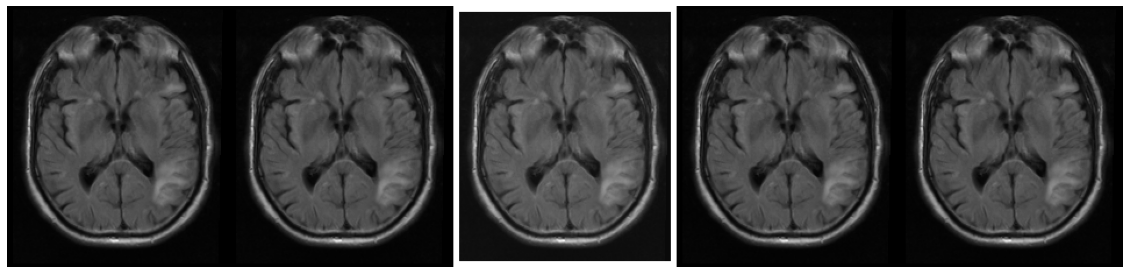

In [132]:
border = 5
X_0[:border] = X_0[-border:] = X_0[:,:border] = X_0[:,-border:] = X_0.max()
img = torch.cat((*X_est[:2], X_0, *X_est[2:]), dim=1)
img = rescale_clip(img)
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

In [ ]:
# find appropriate test subject
nihss_mean,nihss_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[1]
path = osp.join(ANALYSIS_DIR, "2d_mrigenie.dat")
_, val_datalist = pickle.load(open(path, "rb"))
test_ids = []
for dp in val_datalist:
    if np.isnan(dp["attributes"][1].item()):
        continue
    if round(dp["attributes"][1].item() * nihss_scale + nihss_mean) < 10:
        continue
    dp_id = dp["ID"]
    if dp_id.endswith("_0"):
        test_ids.append(dp_id[:dp_id.rfind("_")])
test_ids

In [113]:
# NIHSS
job = "constrained_dit_m_star"
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
nihss_mean,nihss_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[1]
subject_id = "000_FLAIR_TRA_SENSE_0_2100007179"
dp = mrigenie.get_midslice_for_subject(subject_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
base_nihss = round(dp["attributes"][1].item() * nihss_scale + nihss_mean)
print("base age:",base_age, "| base NIHSS:", base_nihss)
models, args = job_mgmt.get_job_model_and_args(job)
model_type = args["network"]["type"]
G=models["G"]
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]

base age: 61 | base NIHSS: 14


In [114]:
gt_ix = 2
nihss_diffs = torch.cat((torch.arange(-20,-4,5), torch.arange(5,21,5)))[4-gt_ix:8-gt_ix]
dY = nihss_diffs.cuda().unsqueeze(1).tile(3)
dY[:,0].zero_()
dY[:,2:].zero_()
X_0 = dp["image"].cuda().unsqueeze(0).tile(4,1,1,1)
attr_gt = dp["attributes"].cuda()
attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0).tile(4,1)
with torch.no_grad():
    if model_type == "CVAE":
        X_est = G(X_0, y=attr_gt, dy=dY/nihss_scale)
    elif model_type == "CAAE":
        attr_targ = attr_gt + (dY/nihss_scale)
        X_est = G(X_0, y=attr_targ)
    else:
        X_est = G(X_0, dY/nihss_scale)
X_est = X_est.cpu().squeeze(1)
X_0 = dp["image"].squeeze()

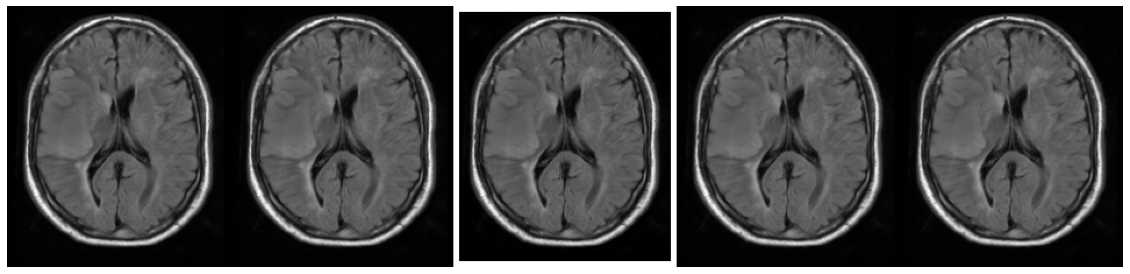

In [115]:
border = 5
X_0[:border] = X_0[-border:] = X_0[:,:border] = X_0[:,-border:] = X_0.max()
img = torch.cat((*X_est[:2], X_0, *X_est[2:]), dim=1)
img = rescale_clip(img)
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

### MRIG raw vs SIT

In [ ]:
# MRIG age
subject_id = "701_STROKE_FLAIR_AX_TRA_TIR_6000_100_90_0_100000483"
jobs = ["raw_m_cvae", "raw_m_ipgan", "raw_m_caae", "raw_m_star",
        "dit_m_cvae", "dit_m_ipgan", "dit_m_caae", "dit_m_star"]

age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
dp = mrigenie.get_midslice_for_subject(subject_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
print("base age:", base_age)
args = job_mgmt.get_job_args(jobs[0])
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]

In [ ]:
output_imgs = []
dY = torch.zeros_like(dp["attributes"]).unsqueeze(0).cuda()
dY[:,0] = 10/age_scale
X_0 = dp["image"].cuda().unsqueeze(0)
attr_gt = dp["attributes"].cuda()
attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0).tile(4,1)
for job in jobs:
    models, args = job_mgmt.get_job_model_and_args(job)
    model_type = args["network"]["type"]
    G=models["G"]
    with torch.no_grad():
        if model_type == "CVAE":
            X_est = G(X_0, y=attr_gt, dy=dY)
        elif model_type == "CAAE":
            attr_targ = attr_gt + dY
            X_est = G(X_0, y=attr_targ)
        else:
            X_est = G(X_0, dY)
    X_est = X_est.cpu().squeeze()
    output_imgs.append(X_est)
plt.rcParams["figure.figsize"] = (5.0, 4.0)
plt.imshow(X_0.squeeze(), cmap="gray"); plt.axis('off');

In [ ]:
top = torch.cat(output_imgs[:4], dim=1)
bot = torch.cat(output_imgs[4:], dim=1)
img = torch.cat((top, bot), dim=0)
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

### MRIG G outputs

In [ ]:
jobs = ["raw_m_star", "st_m_star", "sit_m_star",
        "it_m_star", "dt_m_star", "dit_m_star"]

### Disentangle figure

In [95]:
# path = osp.join(ANALYSIS_DIR, "2d_adni.dat")
# _, val_datalist = pickle.load(open(path, "rb"))

# dps = []
# for dp in val_datalist:
#     if dp["ID"].startswith("137_S_0994") and dp["ID"].endswith("_7"):
#         print(dp["ID"])

In [100]:
# ADNI
series_id = "137_S_0994_109983"
job = "dit_a_star"
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "adni_normalizations.npy"))[0]
dp = adni.get_midslice_for_series(series_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
print("base age:", base_age)
models, args = job_mgmt.get_job_model_and_args(job)
model_type = args["network"]["type"]
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]
G=models["G"]

base age: 57


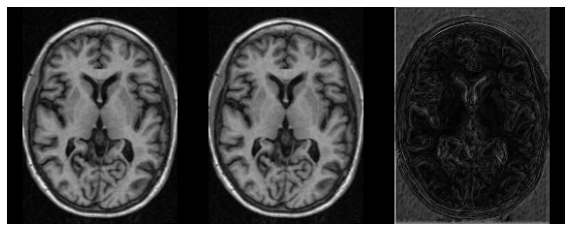

In [107]:
output_imgs = []
dY = torch.zeros_like(dp["attributes"]).unsqueeze(0).cuda()
dY[:,0] = 10/age_scale
X_0 = dp["image"].cuda().unsqueeze(0)
attr_gt = dp["attributes"].cuda()
attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0)
with torch.no_grad():
    if model_type == "CVAE":
        X_est, transforms = G(X_0, y=attr_gt, dy=dY, return_transforms=True)
    elif model_type == "CAAE":
        attr_targ = attr_gt + dY
        X_est, transforms = G(X_0, y=attr_targ, return_transforms=True)
    else:
        X_est, transforms = G(X_0, dY, return_transforms=True)
X_est = rescale_noclip(X_est.cpu().squeeze())
X_0 = rescale_noclip(X_0.cpu().squeeze());
flow = rescale_noclip((transforms[0,1:]).pow(2).sum(0).sqrt().cpu())

img = torch.cat([pad_adni(X_0), pad_adni(X_est), pad_adni(flow)], dim=1)
plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

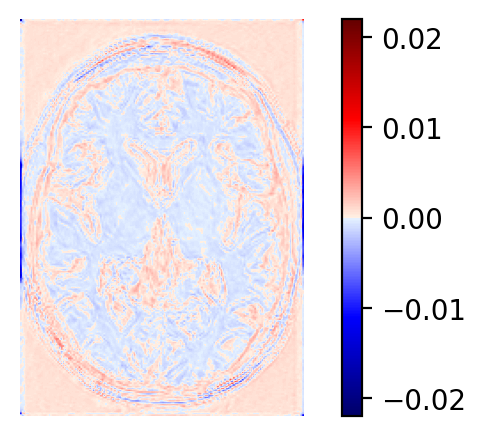

In [105]:
reload(figures)
plt.rcParams["figure.figsize"] = (4.0, 2.0)
diffs = transforms[0,0].cpu()
figures.add_colorplot(diffs)

In [10]:
# MRIG
subject_id = "701_STROKE_FLAIR_AX_TRA_TIR_6000_100_90_0_100000483"
job = "dit_m_cvae"
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
dp = mrigenie.get_midslice_for_subject(subject_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
print("base age:", base_age)
models, args = job_mgmt.get_job_model_and_args(job)
model_type = args["network"]["type"]
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]
G=models["G"]

base age: 52


In [ ]:
output_imgs = []
dY = torch.zeros_like(dp["attributes"]).unsqueeze(0).cuda()
dY[:,0] = 10/age_scale
X_0 = dp["image"].cuda().unsqueeze(0)
attr_gt = dp["attributes"].cuda()
attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0)
with torch.no_grad():
    if model_type == "CVAE":
        X_est, transforms = G(X_0, y=attr_gt, dy=dY, return_transforms=True)
    elif model_type == "CAAE":
        attr_targ = attr_gt + dY
        X_est, transforms = G(X_0, y=attr_targ, return_transforms=True)
    else:
        X_est, transforms = G(X_0, dY, return_transforms=True)
X_est = rescale_noclip(X_est.cpu().squeeze())
X_0 = rescale_noclip(X_0.cpu().squeeze());
flow = rescale_noclip((transforms[0,1:]).pow(2).sum(0).sqrt().cpu())

img = torch.cat([X_0, X_est, flow], dim=1)
plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

In [ ]:
diffs = transforms[0,0].cpu()
diffs = figures.add_colorplot(diffs)
plt.rcParams["figure.figsize"] = (5.0, 4.0)
plt.imshow(diffs.permute(1,2,0)); plt.axis('off');

## Supplementary

In [ ]:
jobs = ["constrained_dit_m_star"]
imgs = figures.compile_trajectory_for_jobs_and_subject(jobs, subject_id)
plt.imshow(imgs); plt.axis('off');

In [ ]:
# ADNI
plt.rcParams["figure.figsize"] = (20.0, 16.0)
jobs = ["raw_a_star", "a_dit2"]#jobs = ["dit_a_star", "sit_a_star"]
subject_id = "137_S_0994" #131_S_1389, 136_S_0695, 136_S_0195
imgs = figures.compile_trajectory_for_jobs_and_subject(jobs, subject_id)
plt.imshow(imgs); plt.axis('off');

# Backup

#### rewrite dataset.bin

In [ ]:
paths["GASROS"]["2D npy subdir"]

In [ ]:
data_dir = "/data/vision/polina/scratch/clintonw/datasets/ADNI/2d_t1"
dataset = pickle.load(open(data_dir+"/dataset.bin", "rb"))

In [ ]:
pickle.dump(new_dps, open(data_dir+"/dataset.bin", "wb"))

In [ ]:
dps = dataset["datapoints"]

In [ ]:
pathsss = glob("/data/vision/polina/scratch/clintonw/amadeus/tmp/backups/ds_instance*")

In [ ]:
ix += 1
path =pathsss[ix]
dataset = pickle.load(open(path, "rb"))
print(dataset["name"])

In [ ]:
for dp in new_dps:
    if not osp.exists(data_dir+"/"+dp["ID"]+".npy"):
        print(dp)

In [ ]:
new_dps = []
for dp in dps:
    props = dp.properties
    props.pop("time instantiated", None)
    props.pop("time last seen", None)
    props.pop("time last modified", None)
    props.pop("originating actions", None)
    #props["observations"]["age"] = props["observations"]["Age"]
    if "estimates" not in props:
        pass
    elif len(props["estimates"]) == 0:
        props.pop("estimates", None)
    else:
        print(dp["name"])
    if "pipeline history" not in props:
        pass
    elif len(props["pipeline history"]) == 0:
        props.pop("pipeline history", None)
    else:
        print(dp["name"])
    new_dp = {"ID": dp["name"], **props}
    new_dps.append(new_dp)

In [ ]:
path = osp.expanduser("~/code/sitgan/configs/mrigenie.yaml")
yaml.dump(paths, open(path, "w"))

In [ ]:
paths["full MRI-GENIE"] = osp.join(paths["MRI-GENIE dataset folder"], "full_mri-genie/ds_instance.bin")

In [ ]:
path = osp.join(paths["MRI-GENIE dataset folder"], "2d_mri-genie_flair", "ds_instance.bin")
out = pickle.load(open(path, "rb"))

In [ ]:
ds = {k:out[k] for k in ["datapoints", "variables", "root folder", "training indices", "validation indices"]}

In [ ]:
dps = []
for dp in out["datapoints"]:
    dp["path"] = out["base image path"](dp)
    dps.append({k:dp[k] for k in ["path", "SiGN ID", "Porpoise ID", "GASROS ID", "clinical site", "sequence name", "observations", "slice number", "total slices"]})

In [ ]:
ds["datapoints"] = dps

In [ ]:
with open(osp.join(paths["MRI-GENIE dataset folder"], "2d_mri-genie_flair.ds"), "wb") as f:
    pickle.dump(ds, f)

### Identify artifacts

In [ ]:
# flip
# 002_AXIAL_FLAIR_400001271, 003_FLAIR_AX_0_600057300,
# 004_AXIAL_FLAIR_400001409, 009_AX_FLAIR_T2_400001742,
# 009_AX_T2_FLAIR_PROPELLER_0_400001882,

# delete:
# 003_HUVUD_FLAIR_TRANS_0_1900000003, 003_HUVUD_FLAIR_TRANS_0_1900000007,
# 003_HUVUD_FLAIR_TRANS_0_1900000017, 003_flair_T2_TIRM_TRA_DARK_FLUID_0_1800000035,
# 003_flair_T2_TIRM_TRA_DARK_FLUID_0_1800000456,
# 003_flair_T2_TIRM_TRA_DARK_FLUID_RS_0_1800000559,
# 004_AXIAL_FLAIR_400001188, 004_FLAIR_TRA_P2_1_1600000004_7
# 004_HUVUD_FLAIR_TRANS_0_1900000011, 005_AXIAL_FLAIR_0_100000291,
# 005_AX_FLAIR_T2_0_2000000721, 005_AX_FLAIR_T2_400001858,
# 005_EP2D_TRA_DARK_FLUIDFLAIR_0_100000038, 005_HUVUD_FLAIR_TRANS_0_1900000418,
# 005_T2_FLAIR_TRA_0_2300000094, 006_AX_FLAIR_T2_400001727,
# 007_AX_FLAIR_T2_400000055, 010_FLAIR_FSE_8_AXIAL_0_600051530,
# 012_T2_FLAIR_TRA_0_2300000687, 701_FLAIR_TRA_0_600058080,

In [ ]:
paths["full MRI-GENIE"] = osp.join(paths["MRI-GENIE dataset folder"], "full_mri-genie.bin")

In [ ]:
for dp in ds["datapoints"]:
    if dp["slice number"] == 7:
        img = np.load(dp["path"])
        plt.imsave(osp.join(paths['HOME'], "downloads", "flairs",
                    osp.basename(dp["path"])[:-4])+".png", img, cmap="gray")

In [ ]:
osp.basename(dp["path"])[:-4]

In [ ]:
plt.imshow(img, cmap="gray"); plt.axis('off');

In [ ]:
img_paths = sorted(glob.glob(osp.join(paths['HOME'], "downloads/flairs/*")))
ix = -1

In [ ]:
ix-=4

In [ ]:
ix += 1
path = img_paths[ix]
img1 = plt.imread(path)
ix += 1
path = img_paths[ix]
img2 = plt.imread(path)
ix += 1
path = img_paths[ix]
img3 = plt.imread(path)
img = np.concatenate((img1, img2, img3), axis=1)
plt.imshow(img, cmap="gray"); plt.axis('off');

In [ ]:
img_paths[ix-2]

In [ ]:
plt.imshow(img1, cmap="gray"); plt.axis('off');